# Risk Model

# 1. Introduction

- Nama Group : 
- Batch : 015
- Dataset : 
- Objectives : 

# 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency


import joblib
import json
import warnings
warnings.simplefilter("ignore")

# 3. Data Loading

In [2]:
# Load Dataset

raw_data = pd.read_excel("IndonesiaCreditData.xlsx", sheet_name="Dataset", )
raw_data.head()

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,NaN,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car


In [3]:
# Droping No columns because its the same as the index number
raw_data.drop('No', axis=1, inplace=True)

In [4]:
# show data tail
raw_data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
995,31,female,1,own,little,NaN,21524664,12,furniture/equipment
996,40,male,3,own,little,little,47822943,30,car
997,38,male,2,own,little,NaN,9968796,12,radio/TV
998,23,male,2,free,little,little,22876155,45,radio/TV
999,27,male,2,own,moderate,moderate,56737824,45,car


In [5]:
# Check Dataset - 1

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


Data terdiri dari `6,135 rows` dan `9 columns` :

- `9 String`

# 5. Data Preprocessing

## 5.2. Get Data for Model Inference

In [6]:
# view dataset size
raw_data.shape[0]

1000

In [7]:
# define inference data counts
inf_count =  round(raw_data.shape[0]*0.05)
inf_count

50

In [8]:
# Get Data for model inference
data_inf = raw_data.sample(inf_count, random_state=33)
data_inf.sample(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
458,27,female,2,own,little,little,4252857,6,domestic appliances
956,49,male,1,own,NaN,rich,45330744,30,radio/TV
275,32,male,2,own,little,NaN,33440103,9,radio/TV
475,26,female,2,rent,little,little,38610486,18,furniture/equipment
943,42,male,1,own,little,NaN,18040545,4,car


In [9]:
# Remove Inference-Set from Dataset

data_train_test = raw_data.drop(data_inf.index)
data_train_test

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,49,male,1,own,little,NaN,25988304,12,education
3,45,male,2,free,little,little,97728918,42,furniture/equipment
5,35,male,1,free,NaN,NaN,112272945,36,education
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,21524664,12,furniture/equipment
996,40,male,3,own,little,little,47822943,30,car
997,38,male,2,own,little,NaN,9968796,12,radio/TV
998,23,male,2,free,little,little,22876155,45,radio/TV


In [10]:
# Reset Index

data_train_test.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)
data_inf.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,26,male,2,own,little,little,59366412,48,car
1,27,male,2,own,little,NaN,107226552,24,business
2,35,male,2,own,moderate,NaN,51468249,24,furniture/equipment
3,53,male,2,free,little,little,60383130,24,car
4,23,female,2,rent,little,NaN,26608254,10,furniture/equipment


In [11]:
# drop data_inf from main dataframe
raw_data_1 = raw_data.drop(data_inf.index)
print(f'old data size: {raw_data.shape[0]}')
print(f'new data size: {raw_data_1.shape[0]}')

old data size: 1000
new data size: 950


## 5.3. Handling empty values

In [12]:
# Duplicate dataset to new one ,if something breaks we can start from here instead from the beginning
raw_data_2 = raw_data_1.copy()

In [13]:
# sum null value
raw_data_2.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     177
Checking account    378
Credit amount         0
Duration              0
Purpose               0
dtype: int64

No Empty value on numerical features

## 5.4. Hadling Outlier

In [14]:
raw_data_3 = raw_data_2.copy()

In [15]:
# Plot outlier for target

def outlier_plot(features):
    # Define figure size
    plt.figure(figsize=(16, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(features, bins=30, kde=True)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=features)
    plt.title('Boxplot')

    plt.show()

In [16]:
# make boundary function
def iqr_calc(feature):
    skew_value = feature.skew()
    if -0.5 > skew_value < 0.5:
        upper_boundary = feature.mean() + 3 * feature.std()
        lower_boundary = feature.mean() - 3 * feature.std()
    else:
        IQR= feature.quantile(0.75) - feature.quantile(0.25)
        lower_boundary= feature.quantile(0.25)-(IQR*1.5)
        upper_boundary= feature.quantile(0.75)+(IQR*1.5)
    return lower_boundary, upper_boundary

In [17]:
# make capping function
def capping_data(dataset, column):
  lower_bound, upper_bound = iqr_calc(dataset[column])
  dataset.loc[dataset[column] > upper_bound, column] = upper_bound
  dataset.loc[dataset[column] < lower_bound, column] = lower_bound
  return dataset

In [18]:
# Get Numerical Columns and Categorical Columns

num_columns = raw_data_3.select_dtypes(include=np.number).columns.tolist()
cat_columns = raw_data_3.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns   : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns   :  ['Age', 'Job', 'Credit amount', 'Duration']
Categorical Columns :  ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


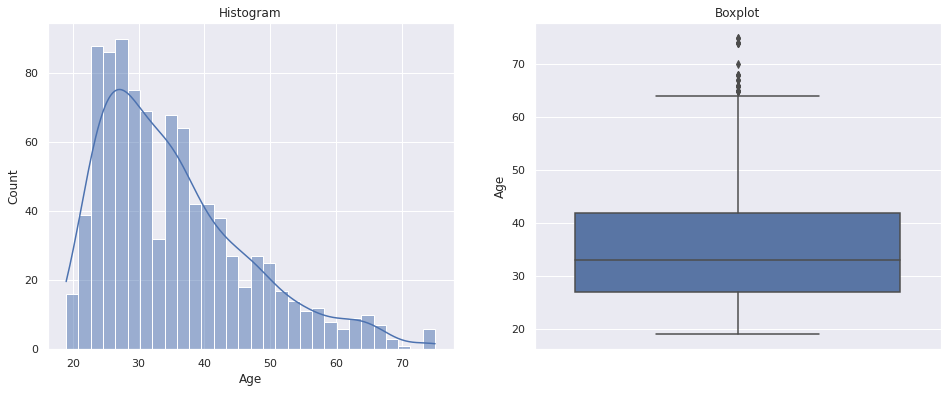

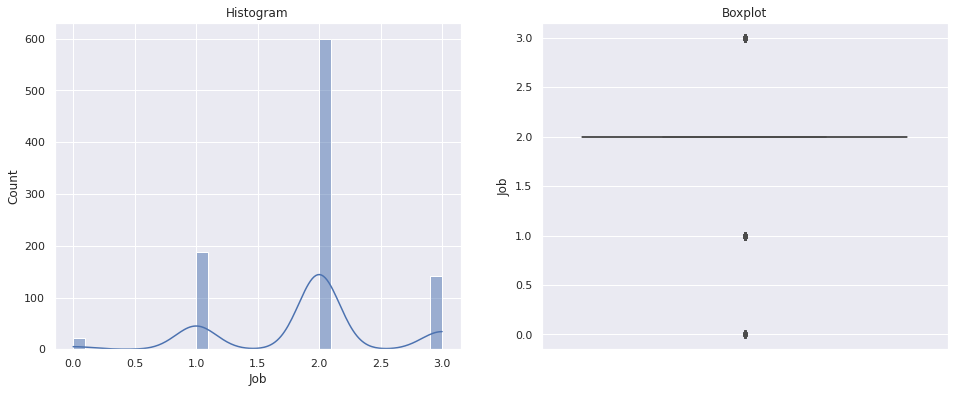

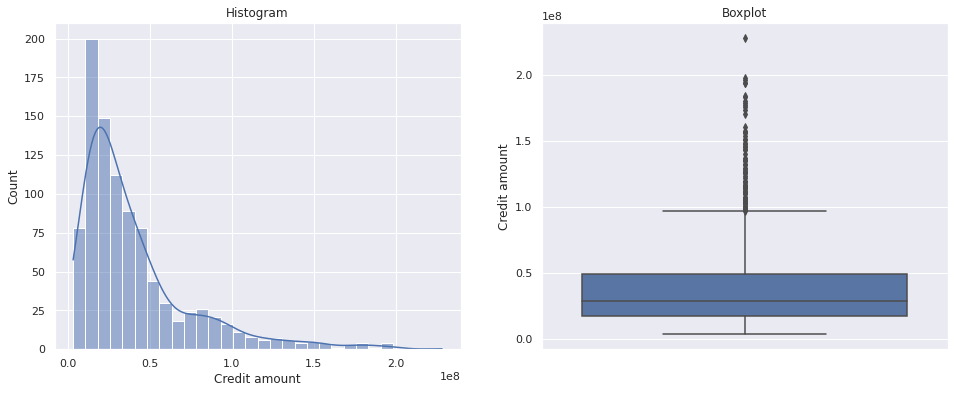

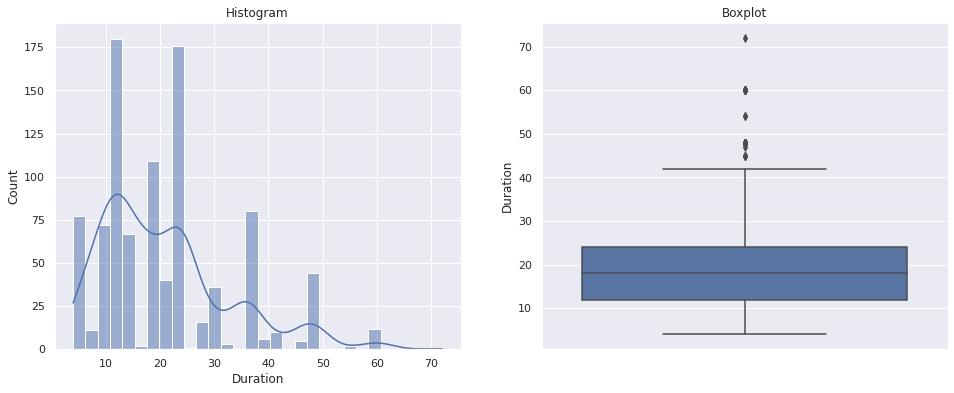

In [19]:
# plotting for numerical columns
for i in num_columns:
  outlier_plot(raw_data_3[i])

In [20]:
# Capping numerical columns
raw_data_4 = raw_data_3.copy()
for i in num_columns:
    capping_data(raw_data_3, i)

## 5.5. Feature Selection

In [21]:
# find corelation between features
data_cor = raw_data_4.corr() 
data_cor

,Age,Job,Credit amount,Duration
Age,1.000000,0.029828,0.033242,-0.038344
Job,0.029828,1.000000,0.293195,0.216235
Credit amount,0.033242,0.293195,1.000000,0.626378
Duration,-0.038344,0.216235,0.626378,1.000000


## 5.6 Feature scaling

In [22]:
raw_num = raw_data_4[num_columns]
raw_cat = raw_data_4[cat_columns]

In [23]:
# Define scaler
scaler = MinMaxScaler()

# Scaled the data
scaler.fit(raw_num)
raw_num_scaled = scaler.transform(raw_num)

In [24]:
# Summarized new data
raw_num_scaled

array([[0.17857143, 0.33333333, 0.11461428, 0.29411765],
       [0.19642857, 1.        , 0.31446022, 0.33823529],
       [0.10714286, 0.66666667, 0.05568394, 0.11764706],
       ...,
       [0.33928571, 0.66666667, 0.03048311, 0.11764706],
       [0.07142857, 0.66666667, 0.08776274, 0.60294118],
       [0.14285714, 0.66666667, 0.23803235, 0.60294118]])

## 5.7 encoding categorical features

In [25]:
# encode using one hot encoding
# Creating instance of one_hot encoder
encoder = OneHotEncoder(sparse=False)

# perform one-hot encoding on categorical column
raw_cat_encoded = encoder.fit_transform(raw_cat)

In [26]:
raw_cat_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [27]:
raw_data_5_arr = np.concatenate((raw_num_scaled, raw_cat_encoded), axis=1 )
raw_data_5_arr

array([[0.17857143, 0.33333333, 0.11461428, ..., 0.        , 0.        ,
        0.        ],
       [0.19642857, 1.        , 0.31446022, ..., 0.        , 0.        ,
        0.        ],
       [0.10714286, 0.66666667, 0.05568394, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.33928571, 0.66666667, 0.03048311, ..., 1.        , 0.        ,
        0.        ],
       [0.07142857, 0.66666667, 0.08776274, ..., 1.        , 0.        ,
        0.        ],
       [0.14285714, 0.66666667, 0.23803235, ..., 0.        , 0.        ,
        0.        ]])

In [28]:
raw_data_5 = pd.DataFrame(raw_data_5_arr)
raw_data_5

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.178571,0.333333,0.114614,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.196429,1.000000,0.314460,0.338235,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.107143,0.666667,0.055684,0.117647,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.214286,0.666667,0.172114,0.205882,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.678571,0.666667,0.108672,0.470588,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0.214286,0.333333,0.081765,0.117647,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
946,0.375000,1.000000,0.198470,0.382353,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
947,0.339286,0.666667,0.030483,0.117647,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
948,0.071429,0.666667,0.087763,0.602941,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 5.8 Checking for Multicollinearity 

In [29]:
# make new dataframe for VIF test
vif_data = pd.DataFrame()
vif_data["feature"] = raw_data_5.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(raw_data_5.values, i) for i in range(len(raw_data_5.columns))]

vif_data

,feature,VIF
0,0,1.169107
1,1,1.131320
2,2,1.892733
3,3,1.753558
4,4,inf
5,5,inf
6,6,inf
7,7,inf
8,8,inf
9,9,inf


## 5.9 Reducing dimension using PCA

In [30]:
# define pca with 95%
pca_scaled=PCA(n_components=0.95).fit(raw_data_5)
pca_scaled.explained_variance_ratio_

array([0.15610691, 0.13362805, 0.11616359, 0.10115978, 0.0865637 ,
       0.07168762, 0.06746356, 0.04410906, 0.04108071, 0.03631687,
       0.02603065, 0.02336499, 0.02179546, 0.01673744, 0.01637683])

In [31]:
# scaled dataset with pca
data_scaled=pca_scaled.transform(raw_data_5)

In [32]:
# summarized new data
data_scaled

array([[-0.45961221,  0.09709713,  0.08899311, ...,  0.03909065,
         0.09252929, -0.29793005],
       [-0.35148895, -0.61923574,  0.22522695, ..., -0.05461392,
        -0.20951289,  0.29186029],
       [-0.60452283,  0.08530588, -0.89398836, ...,  0.04449013,
         0.03372653, -0.01332585],
       ...,
       [-0.61838673,  0.08320486, -0.88763197, ...,  0.05364847,
         0.06606543, -0.0370876 ],
       [ 0.09619566, -0.96459646, -0.05449823, ..., -0.20266147,
         0.06191233, -0.03517227],
       [-0.60292362, -0.0430382 ,  0.61087443, ...,  0.11324796,
        -0.16096144,  0.06555757]])

In [33]:
# compare resemblance new data to original dataframe
np.sum(pca_scaled.explained_variance_ratio_)

0.9585852183109607

# 6. Model Production

In [34]:
# define pca with 2 dimensions
pca_scaled_2d=PCA(n_components=2).fit(raw_data_5)
pca_scaled_2d.explained_variance_ratio_

array([0.15610691, 0.13362805])

In [35]:
# scaled dataset with pca
data_scaled_2d = pca_scaled_2d.transform(raw_data_5)

### Gaussian

In [43]:
# Function to Plot Centroids

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [36]:
# Function to Plot GMM's Decision Boundary

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [37]:
# make 2d gm for visualization
gm_2d_1 = GaussianMixture(n_components=2, random_state=42)
gm_2d_1.fit(data_scaled_2d)

GaussianMixture(n_components=2, random_state=42)

In [38]:
# make 2d gm for visualization
gm_2d_2 = GaussianMixture(n_components=3, random_state=42)
gm_2d_2.fit(data_scaled_2d)

GaussianMixture(n_components=3, random_state=42)

In [39]:
# make 2d gm for visualization
gm_2d_3 = GaussianMixture(n_components=4, random_state=42)
gm_2d_3.fit(data_scaled_2d)

GaussianMixture(n_components=4, random_state=42)

In [40]:
# make 2d gm for visualization
gm_2d_4 = GaussianMixture(n_components=5, random_state=42)
gm_2d_4.fit(data_scaled_2d)

GaussianMixture(n_components=5, random_state=42)

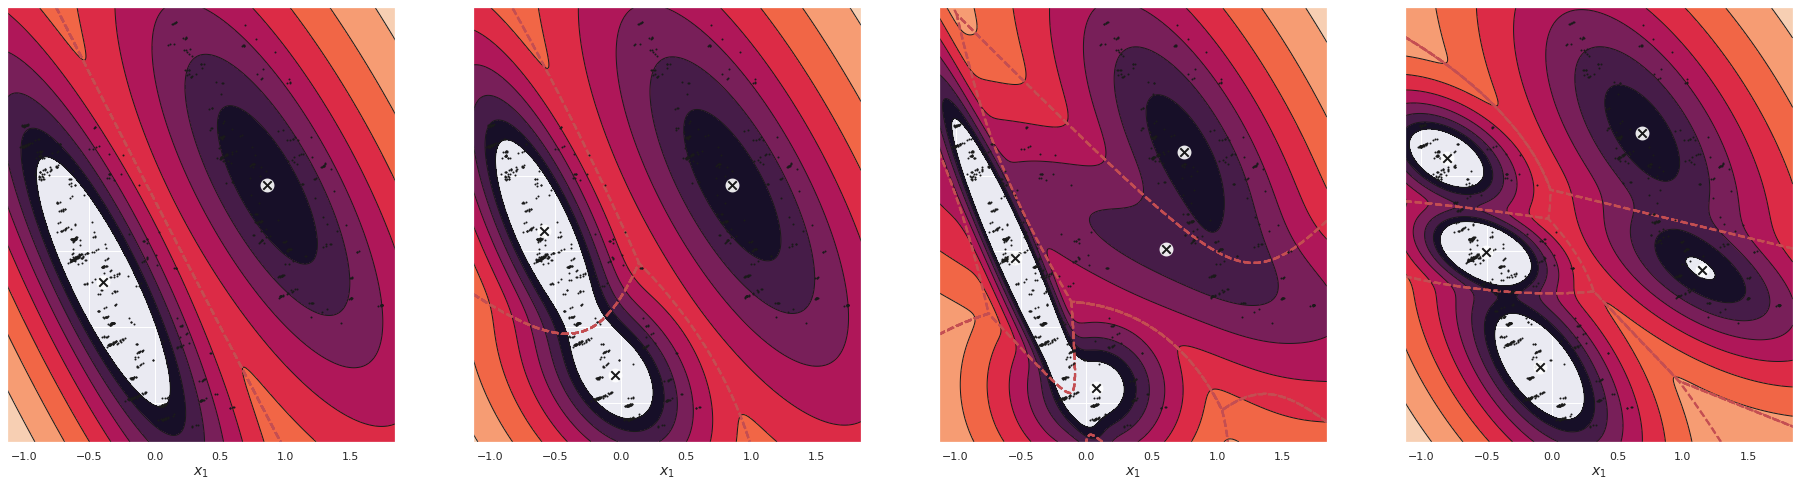

In [44]:
plt.figure(figsize=(32, 8))

plt.subplot(141)
plot_gaussian_mixture(gm_2d_1, data_scaled_2d, show_ylabels=False)

plt.subplot(142)
plot_gaussian_mixture(gm_2d_2, data_scaled_2d, show_ylabels=False)


plt.subplot(143)
plot_gaussian_mixture(gm_2d_3, data_scaled_2d, show_ylabels=False)

plt.subplot(144)
plot_gaussian_mixture(gm_2d_4, data_scaled_2d, show_ylabels=False)

plt.show()

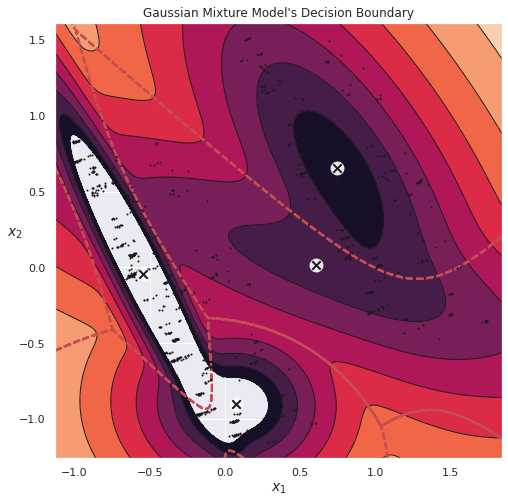

In [46]:
# Plot GMM's Decision Boundary

plt.figure(figsize=(8, 8))
plot_gaussian_mixture(gm_2d_3, data_scaled_2d)
plt.title('Gaussian Mixture Model\'s Decision Boundary')
plt.show()



In [182]:
#GMM akan membuat 10 model (n_init) masing2 ada 3 cluster (n_components) lalu diambil performa terbaiknya
gm = GaussianMixture(n_components=5, random_state=42)
gm.fit(data_scaled)

GaussianMixture(n_components=5, random_state=42)

In [183]:
# Train model
y_pred_2 = gm.predict(data_scaled)

In [184]:
# copy dataframes
results = raw_data_4.copy()

In [185]:
results['Predictions'] = y_pred_2

### Group 0 data exploration

In [186]:
group_0 = results[results['Predictions'] == 0]
group_0.sample(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
400,39,male,2,own,little,NaN,18263727,18,radio/TV,0
849,57,male,1,own,little,little,8790891,12,radio/TV,0
966,23,male,1,own,quite rich,moderate,31245480,27,radio/TV,0


In [187]:
print(f'{group_0["Sex"].value_counts()}')


male    178
Name: Sex, dtype: int64


In [188]:
print(f'median age = {group_0["Age"].median()}')


median age = 33.0


In [189]:
print(f'{group_0["Housing"].value_counts()}')

own     143
rent     22
free     13
Name: Housing, dtype: int64


In [190]:
print(f'{group_0["Saving accounts"].value_counts()}')

little        107
moderate       18
quite rich     14
Name: Saving accounts, dtype: int64


In [191]:
print(f'{group_0["Checking account"].value_counts()}')

moderate    47
little      32
rich        16
Name: Checking account, dtype: int64


In [192]:
print(f'{group_0["Credit amount"].median()}')

23682090.0


In [193]:
print(f'{group_0["Duration"].median()}')

18.0


In [194]:
print(f'{group_0["Purpose"].value_counts()}')

radio/TV    178
Name: Purpose, dtype: int64


### Group 1 data exploration

In [195]:
group_1 = results[results['Predictions'] == 1]
group_1.sample(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
465,63,male,2,own,little,little,36254676,24,car,1
690,25,male,2,own,little,little,12089025,15,furniture/equipment,1
996,40,male,3,own,little,little,47822943,30,car,1


In [196]:
print(f'{group_1["Sex"].value_counts()}')


male      121
female     83
Name: Sex, dtype: int64


In [197]:
print(f'median age = {group_1["Age"].median()}')

median age = 31.0


In [198]:
print(f'{group_1["Housing"].value_counts()}')

own     123
rent     49
free     32
Name: Housing, dtype: int64


In [199]:
print(f'{group_1["Saving accounts"].value_counts()}')

little        167
rich            6
quite rich      4
moderate        1
Name: Saving accounts, dtype: int64


In [200]:
print(f'{group_1["Checking account"].value_counts()}')

little    204
Name: Checking account, dtype: int64


In [201]:
print(f'{group_1["Credit amount"].median()}')

30724722.0


In [202]:
print(f'{group_1["Duration"].median()}')

18.0


In [203]:
print(f'{group_1["Purpose"].value_counts()}')

car                    92
furniture/equipment    68
radio/TV               19
education              15
vacation/others         4
domestic appliances     3
business                2
repairs                 1
Name: Purpose, dtype: int64


### Group 2 data exploration

In [204]:
group_2 = results[results['Predictions'] == 2]
group_2.sample(3)


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
310,40,male,0,free,NaN,moderate,66719019,48,vacation/others,2
827,36,male,2,own,little,NaN,51641835,18,business,2
567,34,male,2,own,rich,NaN,31964622,24,radio/TV,2


In [205]:
print(f'{group_2["Sex"].value_counts()}')

male    272
Name: Sex, dtype: int64


In [206]:
print(f'median age = {group_2["Age"].median()}')

median age = 35.0


In [207]:
print(f'{group_2["Housing"].value_counts()}')

own     212
free     30
rent     30
Name: Housing, dtype: int64


In [208]:
print(f'{group_2["Saving accounts"].value_counts()}')

little        137
rich           23
quite rich     21
moderate       19
Name: Saving accounts, dtype: int64


In [209]:
print(f'{group_2["Checking account"].value_counts()}')

moderate    91
Name: Checking account, dtype: int64


In [210]:
print(f'{group_2["Credit amount"].median()}')

34215040.5


In [211]:
print(f'{group_2["Duration"].median()}')

20.0


In [212]:
print(f'{group_2["Purpose"].value_counts()}')

car                    132
furniture/equipment     50
business                49
education               22
repairs                  7
vacation/others          6
radio/TV                 4
domestic appliances      2
Name: Purpose, dtype: int64


### Group 3 data exploration

In [213]:
group_3 = results[results['Predictions'] == 3]
group_3.sample(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
737,35,male,1,own,moderate,little,54307620,18,car,3
703,41,male,2,own,moderate,moderate,31034697,30,business,3
729,36,male,2,own,rich,rich,15808725,24,business,3


In [214]:
print(f'{group_3["Sex"].value_counts()}')

male    82
Name: Sex, dtype: int64


In [215]:
print(f'median age = {group_3["Age"].median()}')

median age = 34.0


In [216]:
print(f'{group_3["Housing"].value_counts()}')

own     55
free    14
rent    13
Name: Housing, dtype: int64


In [217]:
print(f'{group_3["Saving accounts"].value_counts()}')

little        43
moderate      31
quite rich     3
rich           2
Name: Saving accounts, dtype: int64


In [218]:
print(f'{group_3["Checking account"].value_counts()}')

moderate    35
rich        25
little      22
Name: Checking account, dtype: int64


In [219]:
print(f'{group_3["Credit amount"].median()}')

29410428.0


In [220]:
print(f'{group_3["Duration"].median()}')

22.5


In [221]:
print(f'{group_3["Purpose"].value_counts()}')

car                    35
business               25
repairs                 9
furniture/equipment     8
domestic appliances     3
education               2
Name: Purpose, dtype: int64


### Group 4 data exploration

In [222]:
group_4 = results[results['Predictions'] == 4]
group_4.sample(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
296,20,female,2,rent,NaN,NaN,57965325,12,car,4
102,24,female,2,own,little,NaN,11555868,6,radio/TV,4
410,20,female,2,own,little,moderate,24388833,24,radio/TV,4


In [223]:
print(f'{group_4["Sex"].value_counts()}')

female    214
Name: Sex, dtype: int64


In [224]:
print(f'median age = {group_4["Age"].median()}')

median age = 29.0


In [225]:
print(f'{group_4["Housing"].value_counts()}')

own     146
rent     55
free     13
Name: Housing, dtype: int64


In [226]:
print(f'{group_4["Saving accounts"].value_counts()}')

little        120
moderate       29
rich           14
quite rich     14
Name: Saving accounts, dtype: int64


In [227]:
print(f'{group_4["Checking account"].value_counts()}')

moderate    82
rich        18
Name: Checking account, dtype: int64


In [228]:
print(f'{group_4["Credit amount"].median()}')

25820917.5


In [229]:
print(f'{group_4["Duration"].median()}')

18.0


In [230]:
print(f'{group_4["Purpose"].value_counts()}')

car                    62
radio/TV               61
furniture/equipment    49
education              17
business               16
repairs                 4
domestic appliances     3
vacation/others         2
Name: Purpose, dtype: int64


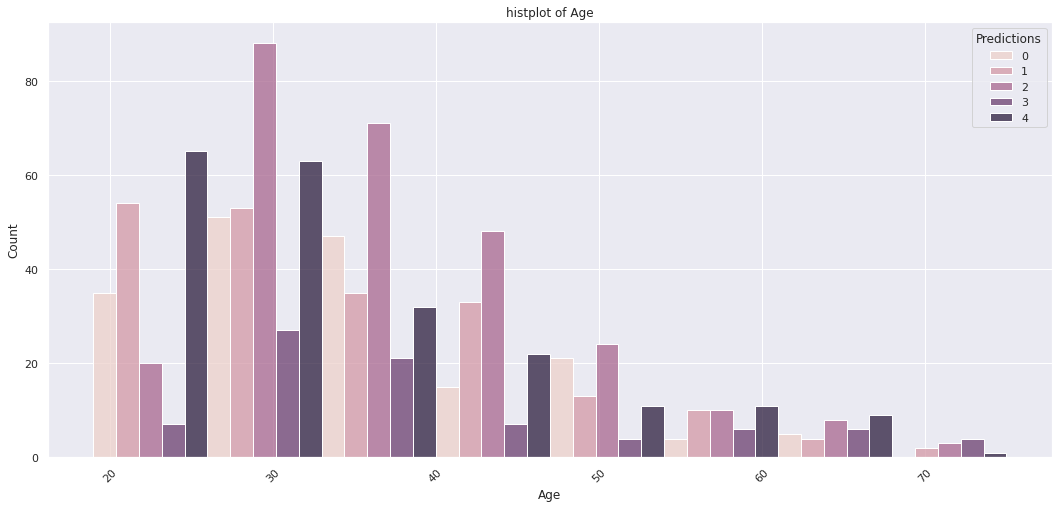

In [276]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.histplot(x=results['Age'], hue=results['Predictions'], multiple='dodge',  bins=8)
plt.xticks(rotation=45)
plt.title('histplot of Age')

plt.show()

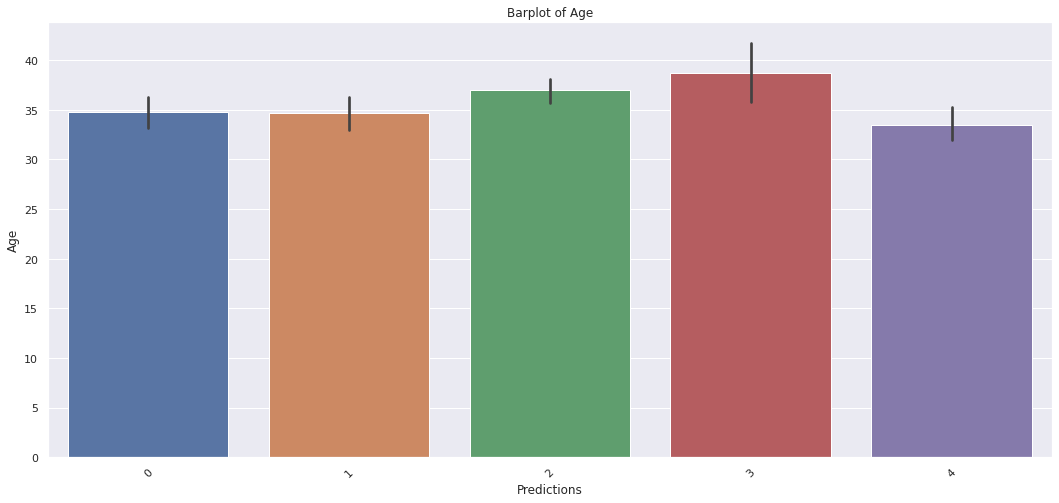

In [279]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.barplot(y=results['Age'], x=results['Predictions'])
plt.xticks(rotation=45)
plt.title('Barplot of Age')

plt.show()

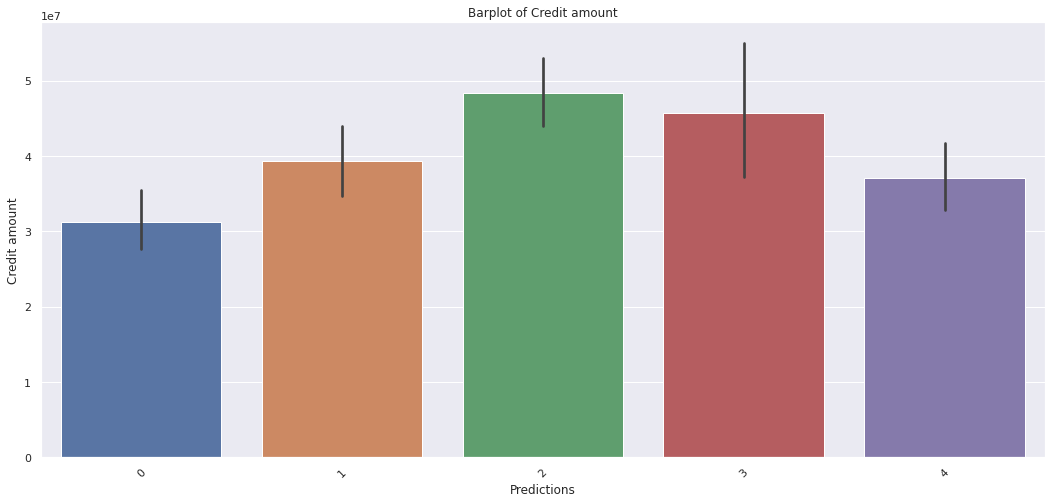

In [277]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.barplot(y=results['Credit amount'], x=results['Predictions'])
plt.xticks(rotation=45)
plt.title('Barplot of Credit amount')

plt.show()

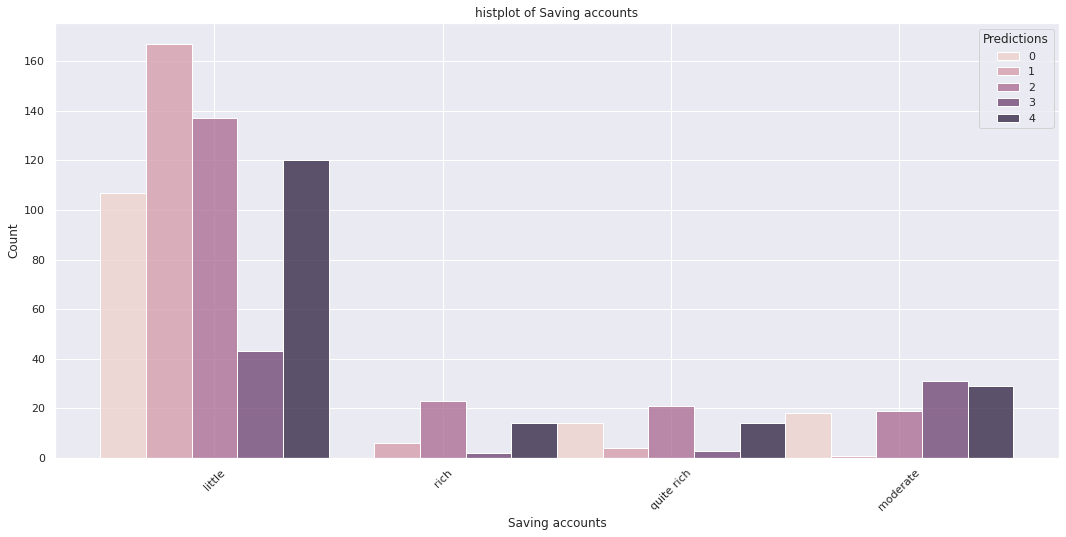

In [244]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.histplot(x=results['Saving accounts'], hue=results['Predictions'], multiple='dodge', bins=8)
plt.xticks(rotation=45)
plt.title('histplot of Saving accounts')

plt.show()

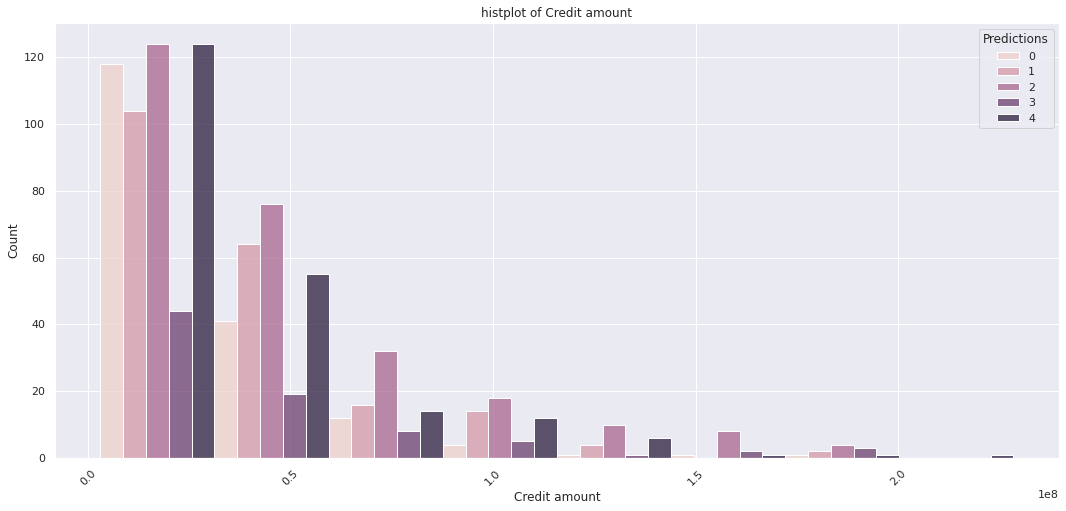

In [275]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.histplot(x=results['Credit amount'], hue=results['Predictions'], multiple='dodge', bins=8)
plt.xticks(rotation=45)
plt.title('histplot of Credit amount')

plt.show()

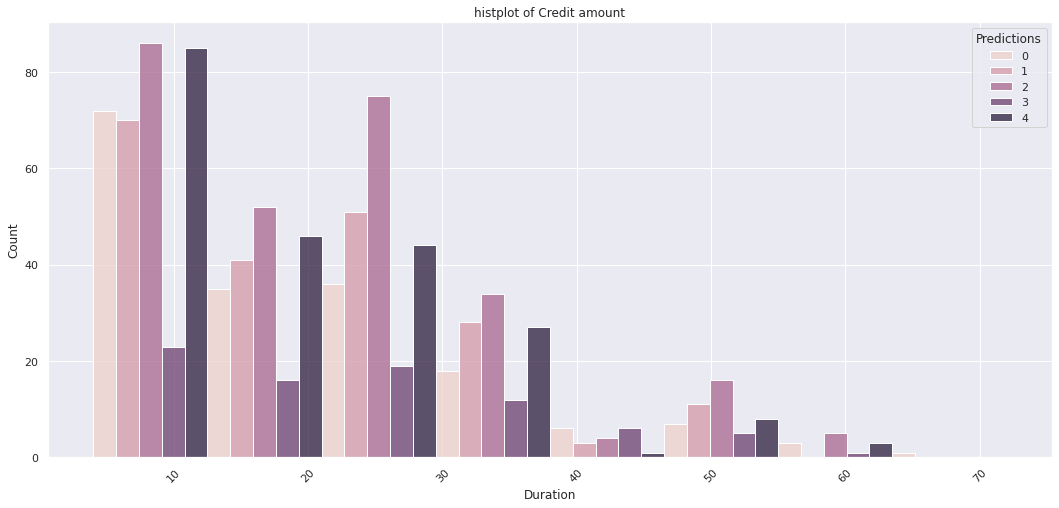

In [247]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.histplot(x=results['Duration'], hue=results['Predictions'], multiple='dodge', bins=8)
plt.xticks(rotation=45)
plt.title('histplot of Credit amount')

plt.show()

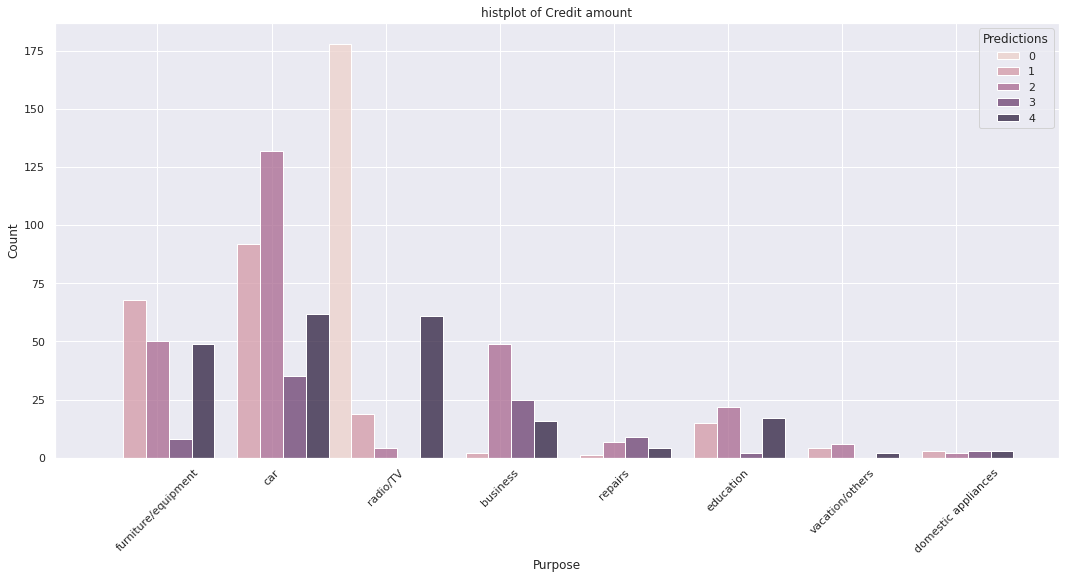

In [248]:
# Create plots

plt.figure(figsize=(18, 8))

# plt.subplot(1,2,1)
sns.histplot(x=results['Purpose'], hue=results['Predictions'], multiple='dodge', bins=8)
plt.xticks(rotation=45)
plt.title('histplot of Credit amount')

plt.show()

### Analysis




# 7. Model Inference

In [231]:
# display inference-set
data_inf.sample(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
18,46,male,2,own,little,little,8642103,12,car
11,27,male,2,own,quite rich,moderate,28840074,15,business
35,40,male,1,rent,little,little,8480916,12,education
26,37,female,2,rent,quite rich,NaN,17383398,12,furniture/equipment
16,28,female,3,rent,little,little,32311794,21,radio/TV


In [232]:
# define numerical columns
data_inf_num = data_inf[num_columns]

data_inf_num.sample(3)

,Age,Job,Credit amount,Duration
47,64,2,9336447,6
40,22,2,16937034,9
25,25,2,15672336,15


In [233]:
# feature sfcaling and feature encoding

data_inf_num_scaled = scaler.transform(data_inf_num)

data_inf_num_scaled

array([[0.125     , 0.66666667, 0.24969737, 0.64705882],
       [0.14285714, 0.66666667, 0.4620887 , 0.29411765],
       [0.28571429, 0.66666667, 0.2146473 , 0.29411765],
       [0.60714286, 0.66666667, 0.25420931, 0.29411765],
       [0.07142857, 0.66666667, 0.10432486, 0.08823529],
       [0.21428571, 0.66666667, 0.06597337, 0.02941176],
       [0.21428571, 0.66666667, 0.14586772, 0.08823529],
       [0.14285714, 0.66666667, 0.0051172 , 0.02941176],
       [0.41071429, 0.33333333, 0.07120062, 0.        ],
       [0.07142857, 0.66666667, 0.03576538, 0.11764706],
       [0.25      , 0.66666667, 0.09948278, 0.29411765],
       [0.14285714, 0.66666667, 0.11422912, 0.16176471],
       [0.625     , 0.66666667, 0.07411687, 0.29411765],
       [0.41071429, 0.66666667, 0.12804006, 0.11764706],
       [0.30357143, 0.66666667, 0.20166171, 0.33823529],
       [0.10714286, 0.33333333, 0.06080114, 0.29411765],
       [0.16071429, 1.        , 0.12963574, 0.25      ],
       [0.44642857, 0.66666667,

In [250]:
data_inf_encoded = encoder.transform(data_inf[cat_columns])

In [251]:
data_inf_encoded

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [253]:
data_inf_arr = np.concatenate((data_inf_num_scaled, data_inf_encoded), axis=1 )
data_inf_final = pd.DataFrame(data_inf_arr)
data_inf_final.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
16,0.160714,1.000000,0.129636,0.250000,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34,0.214286,0.333333,0.528612,0.470588,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.410714,0.666667,0.195554,0.470588,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,0.410714,0.666667,0.128040,0.117647,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49,0.392857,0.666667,0.068945,0.117647,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [254]:
# scaled dataset with pca
inf_scaled=pca_scaled.transform(data_inf_final)

In [255]:
# Train model
inf_pred_2 = gm.predict(inf_scaled)

In [258]:
# Clustering Results for inference
result_table_inf = data_inf.copy()
result_table_inf['Predictions'] = inf_pred_2
result_table_inf.sample(15)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Predictions
44,42,female,2,own,little,moderate,47165796,36,radio/TV,4
1,27,male,2,own,little,NaN,107226552,24,business,2
33,26,male,2,own,NaN,NaN,65069952,21,car,2
14,36,male,2,own,little,moderate,48542085,27,business,2
10,33,male,2,own,little,NaN,25517142,24,repairs,2
7,27,female,2,own,little,little,4252857,6,domestic appliances,1
36,32,male,2,own,little,NaN,33440103,9,radio/TV,0
20,22,female,2,own,little,moderate,19429233,12,radio/TV,4
25,25,male,2,rent,moderate,moderate,15672336,15,car,3
34,31,male,1,own,moderate,moderate,122216943,36,business,3
